## **Задание 1**
В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < *0.05*, то только приблизительно в *5%* случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с ***'2022-01-24' по '2023-01-30'***. Вам нужно сделать симуляцию, как будто мы провели *10000* АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

## Подготовка к работе

In [1]:
# Подгружаем библиотеки и подключаемся к БД
import pandas as pd
import pandahouse
import hashlib
import seaborn as sns
from scipy import stats

connection = {
            'host': 'https://clickhouse.lab.karpov.courses',
            'database':'simulator_20230220',
            'user':'student', 
            'password':'dpo_python_2020'
}



In [4]:
# Создание датафрейма
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-01-24' and toDate(time) <= '2023-01-30' 
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,10234,10234,10234,10234
3,10368,10368,10368,10368


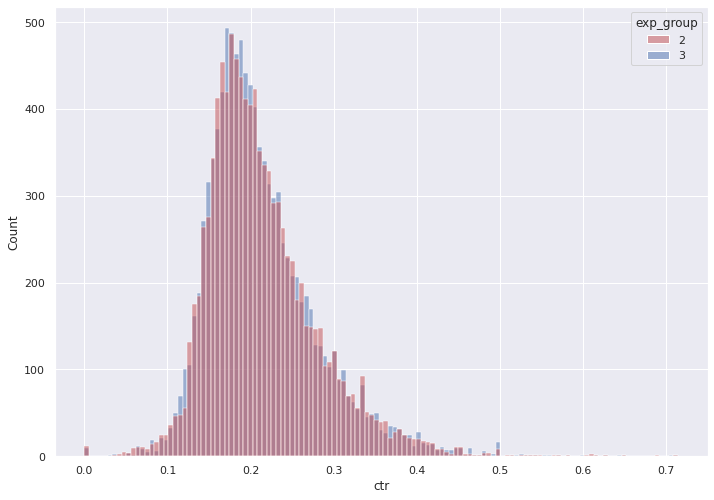

In [5]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df,
                      x = 'ctr',
                      hue = 'exp_group',
                     palette = ['r', 'b'],
                     alpha = 0.5,
                     kde = False)


### Построить гистограмму распределения получившихся 10000 p-values.

In [6]:
data = []

for _ in range(10000):

    group2 = df[df.exp_group == 2].ctr.sample(500)
    group3 = df[df.exp_group == 3].ctr.sample(500)

    data.append(stats.ttest_ind(group2,
                    group3,
                    equal_var=False)[1])
    
df_p_values = pd.DataFrame(data, columns = ['p_values'])

df_p_values.head()

,p_values
0,0.527849
1,0.036912
2,0.403219
3,0.398811
4,0.639713


<AxesSubplot:xlabel='p_values', ylabel='Count'>

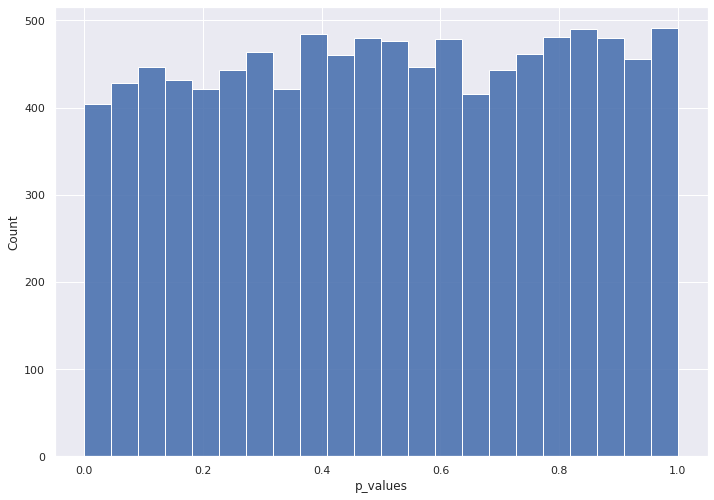

In [7]:
sns.histplot(data = df_p_values,
             x = 'p_values',
             alpha = 0.9,
             kde = False)

### Посчитать, какой процент p values оказался меньше либо равен 0.05

In [8]:
print('У нас получились статистические значимые различия между 2 и 3 группой в {}% случаев '\
      'при уровне значимости 0.05'.\
      format(df_p_values.query('p_values < 0.05').count()[0] * 100/
             df_p_values.count()[0]))

У нас получились статистические значимые различия между 2 и 3 группой в 4.51% случаев при уровне значимости 0.05


### Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Так как статистически значимые различия получились приблизительно в 5% случаев, то мы отвергаем нулевую гипотезу о том, что различия между 2 и 3 группой есть. 
Тогда принимаем альтернативную гипотезу о том, что различий между 2 и 3 группой нет. Для убедительности давайте произведем t-тест и тест Манна-Уитни

### t-тест

In [12]:
p_value = stats.ttest_ind(df.query('exp_group == 2').ctr,
                df[df.exp_group == 3]['ctr'],
                equal_var = False)[1]
print("Отличие не покрасилось, p_value =" if p_value > 0.05
     else "Отличие покрасилось p_value =".format(round(p_value,2)), round(p_value,2))

Отличие не покрасилось, p_value = 0.99


### тест Манна-Уитни

In [13]:
p_value = stats.mannwhitneyu(df.query('exp_group == 2').ctr,
                   df[df.exp_group == 3].ctr)[1]
print('Отличие не покрасилось, p_value = ' + str(p_value) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value))

Отличие не покрасилось, p_value = 0.6979156355781808


Исходя из выше описанных наблюдений, можно сказать, что статистически значимые различия между групп после хэширования **отсутствуют**. Следовательно, можно сделать вывод о том, что АА-тест **работает корректно**!